In [226]:
#импортируем библиотеки
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt


In [227]:
dfPeople=pd.read_csv("application_record.csv")

# СМОТРИМ ПЕРВУЮ ТАБЛИЦУ

In [228]:
dfPeople.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


# СМОТРИМ ВТОРУЮ ТАБЛИЦУ

In [229]:
crr=pd.read_csv("credit_record.csv")

In [230]:
crr['STATUS']=crr['STATUS'].apply(lambda x: '-1' if x=='C' else x)
crr['STATUS']=crr['STATUS'].apply(lambda x: '-2' if x=='X' else x)
crr['STATUS']=crr['STATUS'].astype(int)

In [231]:
max_delay=crr.groupby('ID')['STATUS'].max()

# СОЕДИНИМ ТАБЛИЦЫ

In [232]:
data = pd.merge(dfPeople, max_delay, how='inner', left_on='ID', right_on='ID')

In [233]:
data.drop(columns='ID',inplace=True)

In [234]:
data['STATUS'].value_counts()

 0    27711
 1     3675
-2     3347
-1     1108
 2      314
 5      180
 3       76
 4       46
Name: STATUS, dtype: int64

In [235]:
data['STATUS']=data['STATUS'].apply(lambda x: 0 if x>=2 else 1)

In [236]:
data.drop(columns='OCCUPATION_TYPE',inplace=True)

In [237]:
#DROP duplicates так, что у людей с одинковыми колонками было только макс debt
feature_cols=data.iloc[:,:-1].columns.tolist()


In [238]:
data=data.groupby(feature_cols).agg({'STATUS': 'min'}).reset_index()


In [239]:
data.rename(columns={'STATUS': 'CREDIT_ACCEPT'}, inplace=True)


In [240]:
data[data['DAYS_EMPLOYED']==365243]['CREDIT_ACCEPT'].value_counts()

1    1617
0      82
Name: CREDIT_ACCEPT, dtype: int64

In [241]:
data['CREDIT_ACCEPT'].value_counts()

1    9286
0     442
Name: CREDIT_ACCEPT, dtype: int64

# ТАБЛИЦА ПОДГОТОВЛЕНА

# 2.РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ

In [242]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9728 entries, 0 to 9727
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODE_GENDER          9728 non-null   object 
 1   FLAG_OWN_CAR         9728 non-null   object 
 2   FLAG_OWN_REALTY      9728 non-null   object 
 3   CNT_CHILDREN         9728 non-null   int64  
 4   AMT_INCOME_TOTAL     9728 non-null   float64
 5   NAME_INCOME_TYPE     9728 non-null   object 
 6   NAME_EDUCATION_TYPE  9728 non-null   object 
 7   NAME_FAMILY_STATUS   9728 non-null   object 
 8   NAME_HOUSING_TYPE    9728 non-null   object 
 9   DAYS_BIRTH           9728 non-null   int64  
 10  DAYS_EMPLOYED        9728 non-null   int64  
 11  FLAG_MOBIL           9728 non-null   int64  
 12  FLAG_WORK_PHONE      9728 non-null   int64  
 13  FLAG_PHONE           9728 non-null   int64  
 14  FLAG_EMAIL           9728 non-null   int64  
 15  CNT_FAM_MEMBERS      9728 non-null   f

In [243]:
#закодируем Code_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY в числа


In [244]:
data['CODE_GENDER']=data['CODE_GENDER'].apply(lambda x: 1 if x=='F' else 0)

In [245]:
data['FLAG_OWN_CAR']=data['FLAG_OWN_CAR'].apply(lambda x: 1 if x=='Y' else 0)
data['FLAG_OWN_REALTY']=data['FLAG_OWN_REALTY'].apply(lambda x: 1 if x=='Y' else 0)

In [246]:
#Закодируем EDUCATION TYPE порядковым образом


In [247]:
def code_ed_type(s):
    if(s=='Lower secondary'):
        return 1
    elif(s=='Secondary / secondary special'):
        return 2
    elif(s=='Incomplete higher'):
        return 3
    elif(s=='Higher education'):
        return 4
    else:
        return 5

In [248]:
data['NAME_EDUCATION_TYPE']=data['NAME_EDUCATION_TYPE'].apply(lambda x: code_ed_type(x))

365243


<AxesSubplot:>

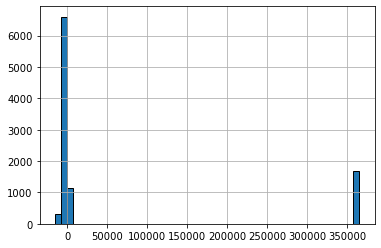

In [249]:
#Разберемся с DAYS_BIRTH и DAYS_EMPLOYED
#data[data['DAYS_EMPLOYED']!=data['DAYS_EMPLOYED'].mode[0]]
nulls=data['DAYS_EMPLOYED'].mode()[0]
print(nulls)
med=int(data[data['DAYS_EMPLOYED'] != nulls]['DAYS_EMPLOYED'].median())
data['DAYS_EMPLOYED'].hist(bins=50, edgecolor='black')

In [250]:
data['DAYS_EMPLOYED']=data['DAYS_EMPLOYED'].apply(lambda x: med if x==nulls else x)

In [251]:
data['DAYS_EMPLOYED'].mean()

-2384.0412212171054

<AxesSubplot:>

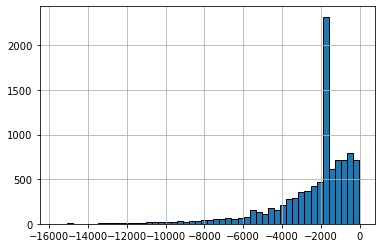

In [252]:
data['DAYS_EMPLOYED'].hist(bins=50, edgecolor='black')

In [253]:
data['FLAG_MOBIL'].value_counts()

1    9728
Name: FLAG_MOBIL, dtype: int64

In [254]:
#убрали лишние признаки
data.drop(columns=['FLAG_MOBIL','CNT_CHILDREN'],inplace=True)

In [255]:
data

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CREDIT_ACCEPT
0,1,0,0,27000.0,Working,4,Civil marriage,House / apartment,-14869,-5067,1,0,0,2.0,1
1,1,0,0,31500.0,Pensioner,2,Married,House / apartment,-20836,-1800,0,0,0,2.0,1
2,1,0,0,33300.0,Pensioner,2,Married,Office apartment,-19605,-1800,0,0,0,2.0,1
3,1,0,0,33750.0,Pensioner,4,Married,House / apartment,-19054,-1800,0,0,0,2.0,1
4,1,0,0,36000.0,Working,2,Married,With parents,-14500,-459,1,0,0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9723,0,1,1,67500.0,Working,2,Married,House / apartment,-13740,-2064,0,0,0,6.0,1
9724,0,1,1,157500.0,Working,4,Married,House / apartment,-11380,-1734,0,0,0,6.0,1
9725,0,1,1,292500.0,Working,2,Married,House / apartment,-14150,-401,0,0,0,6.0,1
9726,0,1,1,202500.0,Working,2,Married,Co-op apartment,-11384,-2727,0,0,0,7.0,1


In [256]:
#Закодируем категориальные

In [257]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9728 entries, 0 to 9727
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODE_GENDER          9728 non-null   int64  
 1   FLAG_OWN_CAR         9728 non-null   int64  
 2   FLAG_OWN_REALTY      9728 non-null   int64  
 3   AMT_INCOME_TOTAL     9728 non-null   float64
 4   NAME_INCOME_TYPE     9728 non-null   object 
 5   NAME_EDUCATION_TYPE  9728 non-null   int64  
 6   NAME_FAMILY_STATUS   9728 non-null   object 
 7   NAME_HOUSING_TYPE    9728 non-null   object 
 8   DAYS_BIRTH           9728 non-null   int64  
 9   DAYS_EMPLOYED        9728 non-null   int64  
 10  FLAG_WORK_PHONE      9728 non-null   int64  
 11  FLAG_PHONE           9728 non-null   int64  
 12  FLAG_EMAIL           9728 non-null   int64  
 13  CNT_FAM_MEMBERS      9728 non-null   float64
 14  CREDIT_ACCEPT        9728 non-null   int64  
dtypes: float64(2), int64(10), object(3)
me

In [258]:
data['AMT_INCOME_TOTAL']=data['AMT_INCOME_TOTAL'].astype(int)
data['CNT_FAM_MEMBERS']=data['CNT_FAM_MEMBERS'].astype(int)

In [259]:
data=pd.get_dummies(data,drop_first=True)

In [260]:
data['CREDIT_ACCEPT2']=data['CREDIT_ACCEPT']
data.drop(columns='CREDIT_ACCEPT',inplace=True)
data = data.rename(columns={'CREDIT_ACCEPT2': 'CREDIT_ACCEPT'})

# SMOTE



In [293]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

# 3 ПОСТРОЕНИЕ ML МОДЕЛЕЙ

In [294]:
from sklearn.model_selection import train_test_split
X=data.drop(columns='CREDIT_ACCEPT')
y=data['CREDIT_ACCEPT']
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.25, random_state=42)
Xtrain, ytrain = smote.fit_resample(X, y)

In [295]:
#масштабируем данным\е
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(Xtrain)
Xtrain=pd.DataFrame(scaler.transform(Xtrain),columns=Xtrain.columns)
Xtest=pd.DataFrame(scaler.transform(Xtest),columns=Xtest.columns)

In [296]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(class_weight='balanced')
model.fit(Xtrain,ytrain)
pred_lr_train=model.predict_proba(Xtrain)[:,1]
pred_lr_test=model.predict_proba(Xtest)[:,1]
pred=model.predict(Xtest)

In [297]:
(pred_lr_train).mean()

0.5000028247079107

In [298]:
from sklearn.metrics import roc_auc_score

roc_auc_score(ytest,pred_lr_test)


0.4904567429744586

In [299]:
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score

In [303]:
cbc = CatBoostClassifier(
    learning_rate=0.5,
    eval_metric='AUC',
    auto_class_weights='Balanced',
    random_seed=42,
    logging_level='Silent'
)


In [304]:
cbc.fit(
    Xtrain, ytrain,
#    eval_set=(Xtest, ytest),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [310]:
ytest.value_counts()

1    2335
0      97
Name: CREDIT_ACCEPT, dtype: int64

In [311]:
from sklearn.ensemble import RandomForestClassifier

In [312]:
params = {'n_estimators': np.arange(10, 80, 10),
          'max_depth': np.arange(2, 30, 3)}

gs = GridSearchCV(RandomForestClassifier(class_weight='balanced',n_jobs=-1), params, cv=3, scoring='roc_auc', verbose=2)

gs.fit(Xtrain, ytrain)

Fitting 3 folds for each of 70 candidates, totalling 210 fits
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=40; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=40; total time=   0.1s
[CV] END .......................max_depth=2, n_

[CV] END ......................max_depth=14, n_estimators=60; total time=   0.2s
[CV] END ......................max_depth=14, n_estimators=70; total time=   0.3s
[CV] END ......................max_depth=14, n_estimators=70; total time=   0.3s
[CV] END ......................max_depth=14, n_estimators=70; total time=   0.3s
[CV] END ......................max_depth=17, n_estimators=10; total time=   0.0s
[CV] END ......................max_depth=17, n_estimators=10; total time=   0.0s
[CV] END ......................max_depth=17, n_estimators=10; total time=   0.0s
[CV] END ......................max_depth=17, n_estimators=20; total time=   0.1s
[CV] END ......................max_depth=17, n_estimators=20; total time=   0.1s
[CV] END ......................max_depth=17, n_estimators=20; total time=   0.0s
[CV] END ......................max_depth=17, n_estimators=30; total time=   0.1s
[CV] END ......................max_depth=17, n_estimators=30; total time=   0.1s
[CV] END ...................

[CV] END ......................max_depth=29, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=29, n_estimators=60; total time=   0.3s
[CV] END ......................max_depth=29, n_estimators=60; total time=   0.3s
[CV] END ......................max_depth=29, n_estimators=60; total time=   0.3s
[CV] END ......................max_depth=29, n_estimators=70; total time=   0.4s
[CV] END ......................max_depth=29, n_estimators=70; total time=   0.4s
[CV] END ......................max_depth=29, n_estimators=70; total time=   0.3s


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1),
             param_grid={'max_depth': array([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29]),
                         'n_estimators': array([10, 20, 30, 40, 50, 60, 70])},
             scoring='roc_auc', verbose=2)

In [223]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [224]:
rfc = RandomForestClassifier(class_weight='balanced')

cross_val_score(rfc, X, y, cv=3, scoring='roc_auc').mean()

0.8737067483744543

In [314]:
gs.best_score_, gs.best_estimator_

(0.904667652217027,
 RandomForestClassifier(class_weight='balanced', max_depth=29, n_estimators=70,
                        n_jobs=-1))

In [315]:
rfc_pred_test=gs.predict_proba(Xtest)[:,1]

In [316]:
roc_auc_score(ytest,rfc_pred_test)

1.0